ประกาศตัวแปร

In [33]:
ROOT_PATH = "~/ChestXray-14/results/confusion"

เลือกโมเดลที่ต้องการ

In [34]:
fold_num = 1
model_name = f"Resnet50_fold_{fold_num}"

อ่านจากไฟล์ประวัติ Threshold เทียบกับ Confusion metrics ของแต่ละโมเดล

In [35]:
import numpy as np
import pandas as pd
from modules.dataset import LABELS

In [36]:
def preprocessing_data(x):
    if "e+" in x:
        values = eval(x.replace(" ", ", "))
        return np.array(values)
    else:
        values = eval(x.replace("\n", "").replace(". ", ".,"))
        return np.array(values)

In [37]:
df = pd.read_csv(f"{ROOT_PATH}/{model_name}.csv")
thresholds = df["thresholds"].values
TP = df["TP"].apply(preprocessing_data).values
TN = df["TN"].apply(preprocessing_data).values
FP = df["FP"].apply(preprocessing_data).values
FN = df["FN"].apply(preprocessing_data).values

แสดงผล

In [38]:
f1_thresholds_dict = dict()
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(TP, TN, FP, FN)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [40]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    best_multiple_f1_list = []
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)
        
        y = np.array(y)
        best = y.argmax()
        sns.scatterplot(x=[x[best]], y=[y[best]], marker="X", s=300)
        
        best_multiple_f1_list.append(x[y.argmax()])

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()
    return best_multiple_f1_list

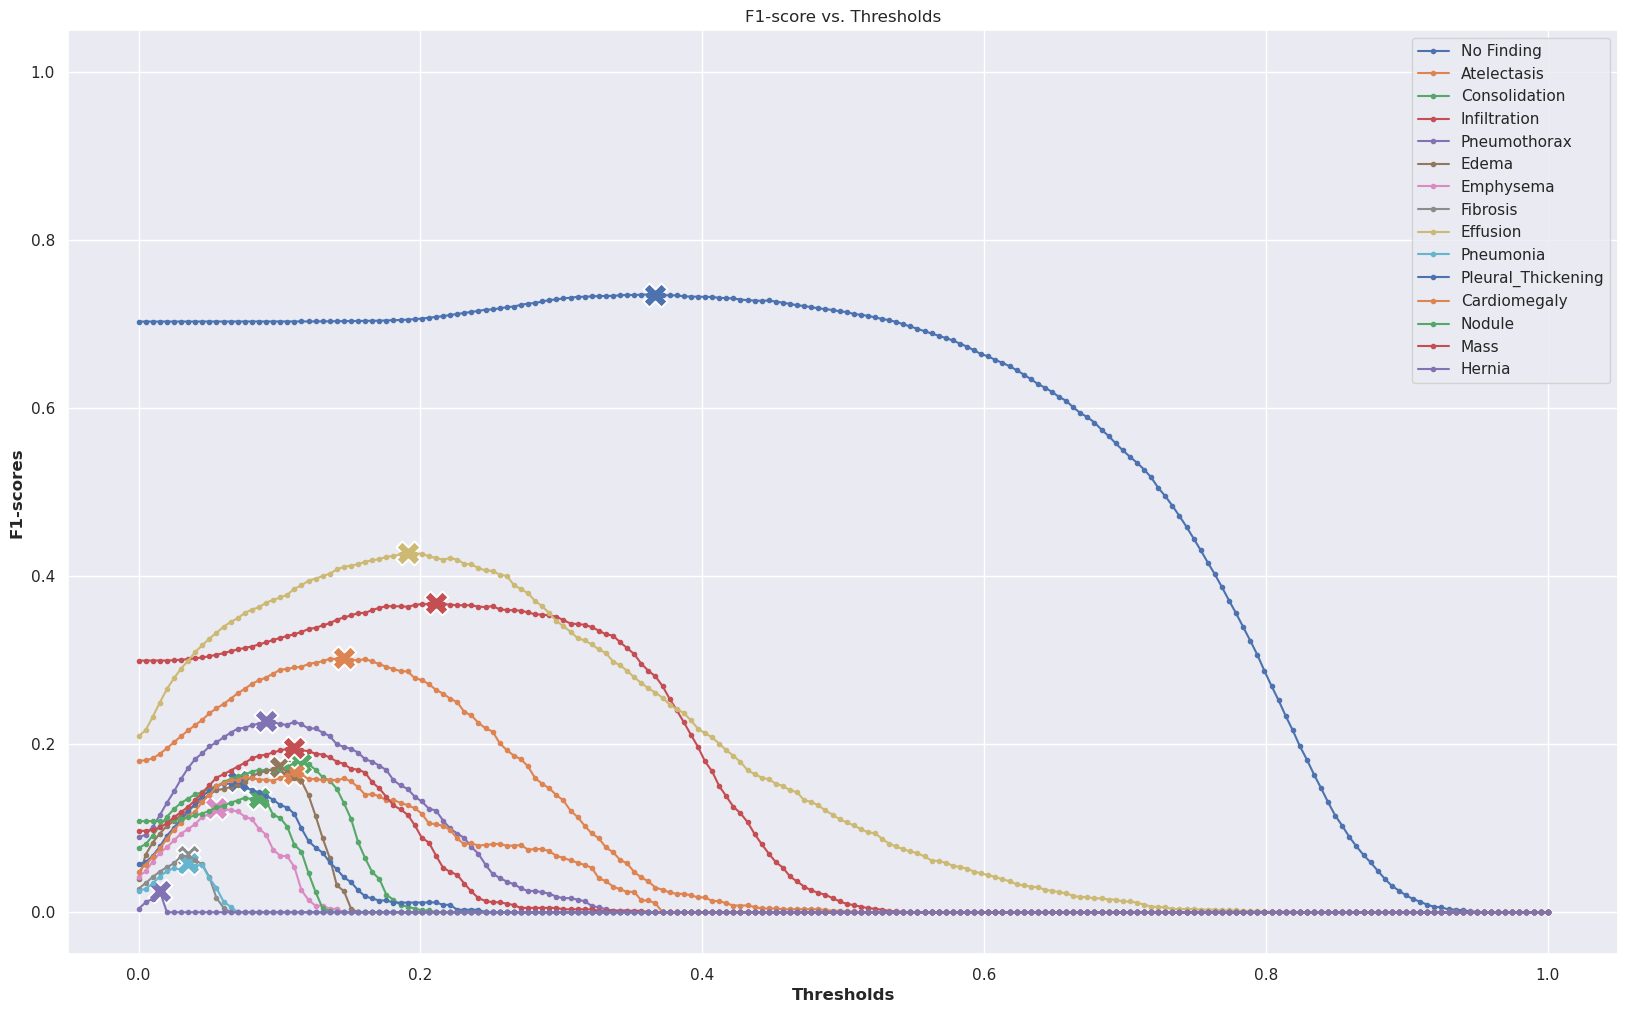

In [41]:
best_multiple_threshold = plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

In [42]:
best_multiple_threshold

[0.3668341708542713,
 0.1457286432160804,
 0.1155778894472361,
 0.2110552763819095,
 0.0904522613065326,
 0.100502512562814,
 0.0552763819095477,
 0.0351758793969849,
 0.1909547738693467,
 0.0351758793969849,
 0.0703517587939698,
 0.1105527638190954,
 0.0854271356783919,
 0.1105527638190954,
 0.0150753768844221]

ลองทำนายด้วยค่า Multiple threshold

In [43]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [44]:
import tensorflow as tf
from modules.dataset import Dataset

In [47]:
dataset = Dataset()

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

model_name = f"Resnet50_imagenet_fold_{fold_num}"

# Modeling
model = tf.keras.models.load_model(f"results/models/{model_name}.h5")

In [48]:
y_preds = model.predict(test_dataset)

2022-12-01 06:20:52.732210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-01 06:20:54.019434: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 06:20:54.021536: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 06:20:54.021598: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-01 06:20:54.022880: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 06:20:54.023113: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      5/Unknown - 8s 27ms/step

2022-12-01 06:20:57.487713: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 46s 28ms/step


In [49]:
y_preds

array([[0.23478016, 0.31409878, 0.12277763, ..., 0.03492339, 0.05093468,
        0.00408405],
       [0.4033821 , 0.0677271 , 0.03449521, ..., 0.13183035, 0.15685375,
        0.00285106],
       [0.55648667, 0.29716375, 0.04966458, ..., 0.02131603, 0.01471604,
        0.00134897],
       ...,
       [0.2848135 , 0.07631592, 0.06126678, ..., 0.18769999, 0.19200735,
        0.00148052],
       [0.20646247, 0.23807567, 0.17744663, ..., 0.03449933, 0.03636177,
        0.00202361],
       [0.39748362, 0.07720686, 0.05000602, ..., 0.1311697 , 0.13178939,
        0.00463559]], dtype=float32)

In [50]:
!pip install tensorflow_addons

  Using cached tensorflow_addons-0.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [51]:
best_multiple_threshold

[0.3668341708542713,
 0.1457286432160804,
 0.1155778894472361,
 0.2110552763819095,
 0.0904522613065326,
 0.100502512562814,
 0.0552763819095477,
 0.0351758793969849,
 0.1909547738693467,
 0.0351758793969849,
 0.0703517587939698,
 0.1105527638190954,
 0.0854271356783919,
 0.1105527638190954,
 0.0150753768844221]

In [52]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold[:5]}\n{threshold[5:10]}\n{threshold[10:]}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

In [53]:
import numpy as np
import tensorflow_addons as tfa

def run_confusion_metrics():
    fig = plt.figure(figsize=(35,20))
    thresh_value = best_multiple_threshold
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true,
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()

<Figure size 3500x2000 with 0 Axes>

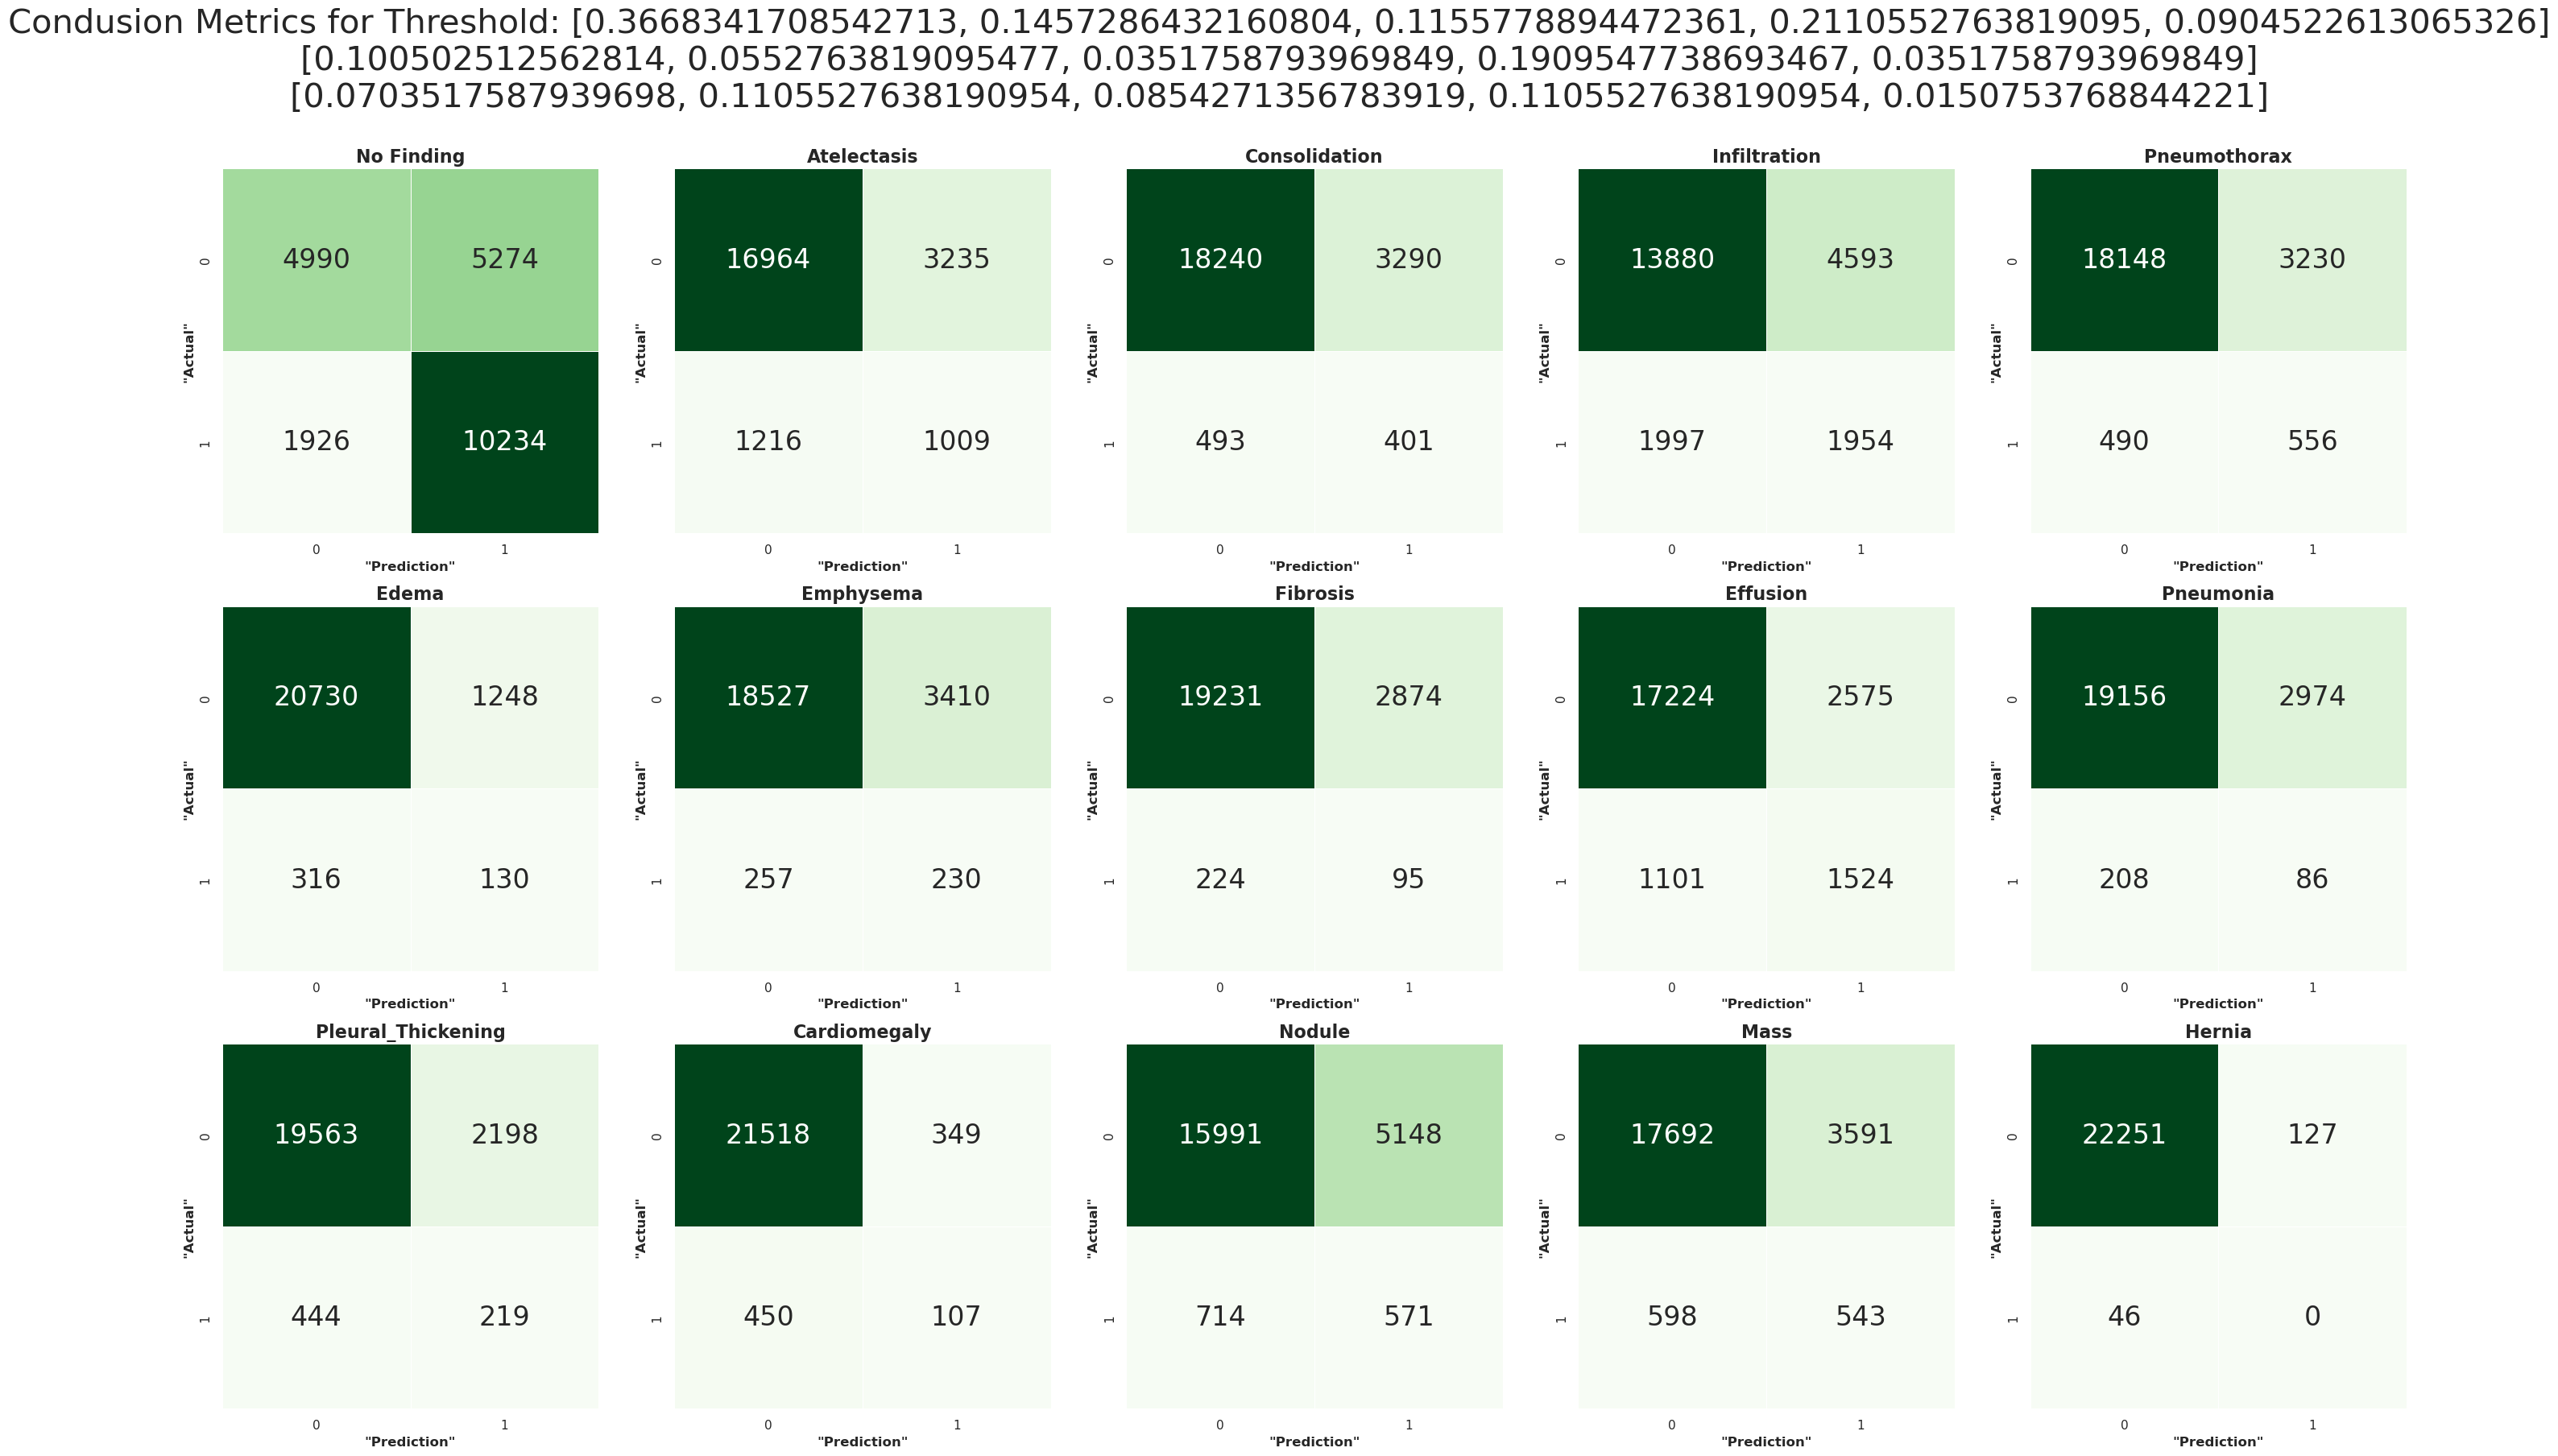

In [54]:
run_confusion_metrics()